# Decision Trees vs Random Forests — Tutorial Notebook

**Focus:** How tree depth affects underfitting and overfitting in Decision Trees, and how Random Forests mitigate variance.

This notebook is designed to be runnable as-is. It uses a synthetic 2D dataset so decision boundaries are easy to visualise. The notebook covers data generation, model training, evaluation, plotting decision boundaries, and a comparison with Random Forests.

**Notebook filename:** `decision_tree_random_forest_tutorial.ipynb`

---


In [1]:
# Imports (run this cell first)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
print('Libraries loaded successfully.')


Libraries loaded successfully.


## 1) Generate a synthetic 2D classification dataset

We generate a two-class problem with two informative features so we can plot decision boundaries easily.

In [2]:
# Generate synthetic 2D dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=1.0, random_state=42)
df = pd.DataFrame(X, columns=['x1','x2'])
df['y'] = y
df.head()


,x1,x2,y
0,0.601034,1.535353,1
1,0.755945,-1.172352,0
2,1.354479,-0.948528,0
3,3.103090,0.233485,0
4,0.753178,0.787514,1


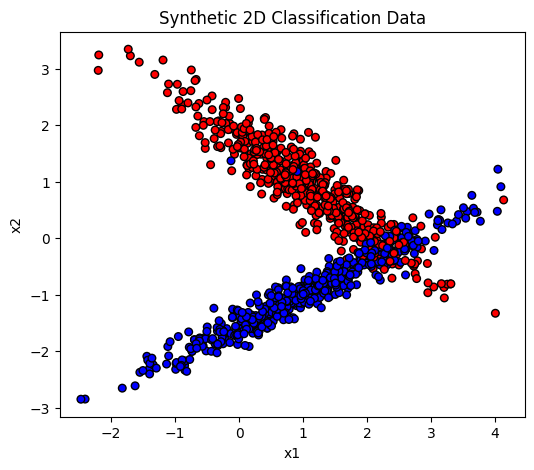

In [3]:
# Scatter plot of the dataset
plt.figure(figsize=(6,5))
plt.scatter(df['x1'], df['x2'], c=df['y'], cmap='bwr', edgecolor='k', s=30)
plt.title('Synthetic 2D Classification Data')
plt.xlabel('x1'); plt.ylabel('x2')
plt.show()


In [4]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])


Train size: 700 Test size: 300


In [5]:
# Utility: decision boundary plotting for 2D
def plot_decision_boundary(clf, X, y, title='Decision boundary', ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    # create mesh
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap_points, edgecolor='k', s=20)
    ax.set_title(title)
    ax.set_xlabel('x1'); ax.set_ylabel('x2')
    if show:
        plt.show()


## 2) Train Decision Trees with varying `max_depth`

We will train Decision Trees with depths [1, 2, 3, 5, 10, None] and compare train vs test accuracy to illustrate underfitting / overfitting.

In [6]:
depths = [1, 2, 3, 5, 10, None]
results = []
models = {}
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results.append({'max_depth': str(d), 'train_acc': train_acc, 'test_acc': test_acc})
    models[str(d)] = clf

results_df = pd.DataFrame(results)
results_df


,max_depth,train_acc,test_acc
0,1,0.897143,0.910000
1,2,0.930000,0.926667
2,3,0.948571,0.930000
3,5,0.972857,0.930000
4,10,0.992857,0.923333
5,None,1.000000,0.926667


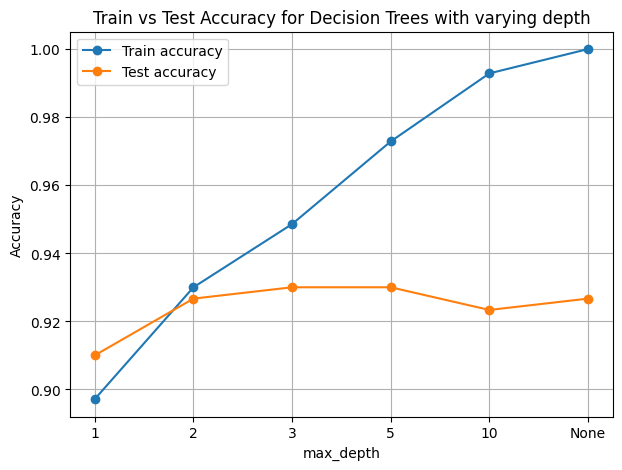

In [7]:
# Plot train and test accuracy vs depth
plt.figure(figsize=(7,5))
x = range(len(results_df))
plt.plot(x, results_df['train_acc'], marker='o', label='Train accuracy')
plt.plot(x, results_df['test_acc'], marker='o', label='Test accuracy')
plt.xticks(x, results_df['max_depth'])
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Decision Trees with varying depth')
plt.legend()
plt.grid(True)
plt.show()


### Decision boundaries for selected depths (1, 3, 10, None)

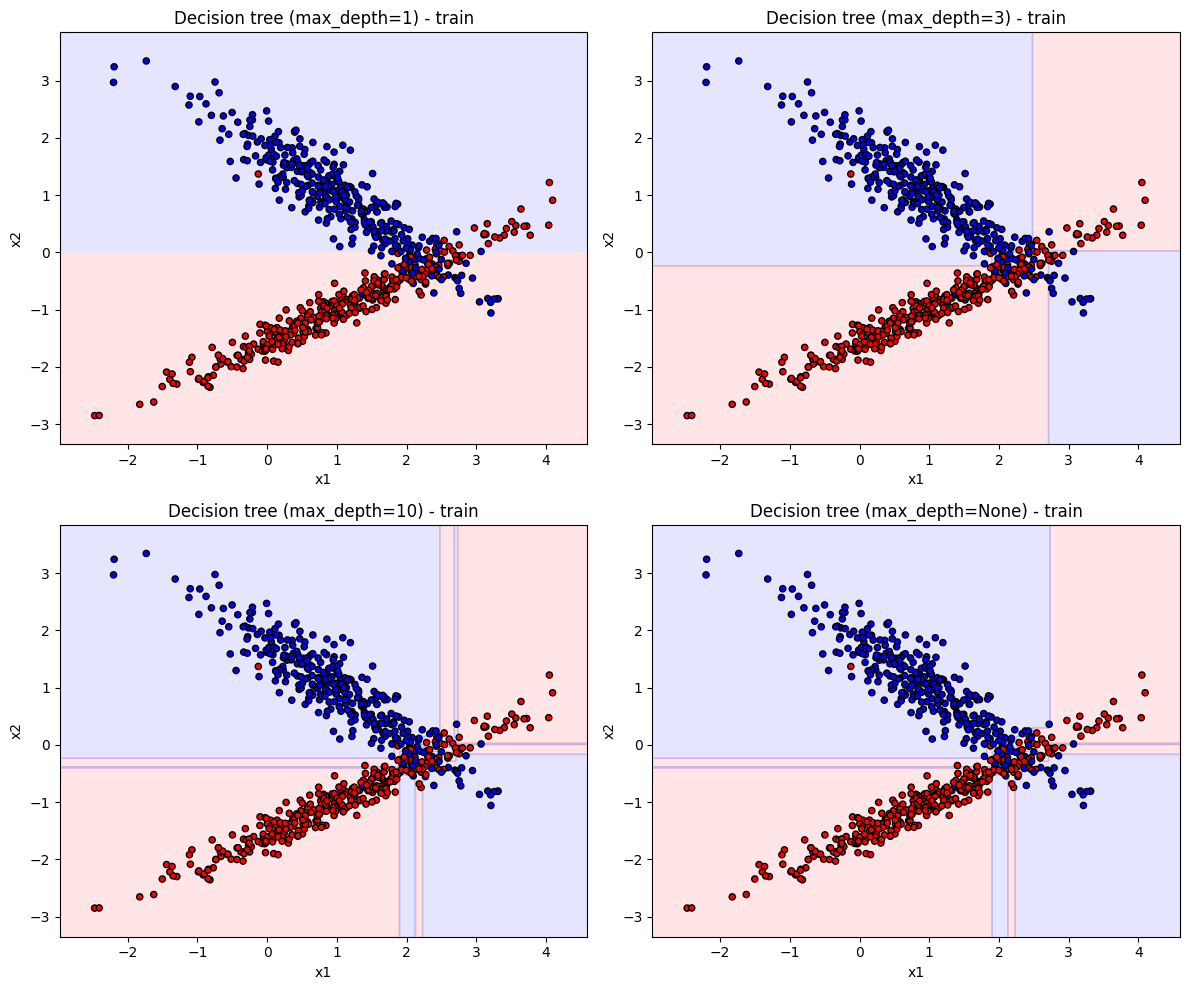

In [8]:
fig, axes = plt.subplots(2,2, figsize=(12,10))
selected = ['1','3','10','None']
for ax, d in zip(axes.ravel(), selected):
    clf = models[d]
    plot_decision_boundary(clf, X_train, y_train, title=f'Decision tree (max_depth={d}) - train', ax=ax, show=False)
plt.tight_layout()
plt.show()


## 3) Compare with Random Forest

Train a Random Forest with default parameters and compare accuracy and decision boundary.

In [9]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)
print('Random Forest train acc:', accuracy_score(y_train, y_train_rf))
print('Random Forest test acc :', accuracy_score(y_test, y_test_rf))


Random Forest train acc: 1.0
Random Forest test acc : 0.9333333333333333


<Figure size 600x500 with 0 Axes>

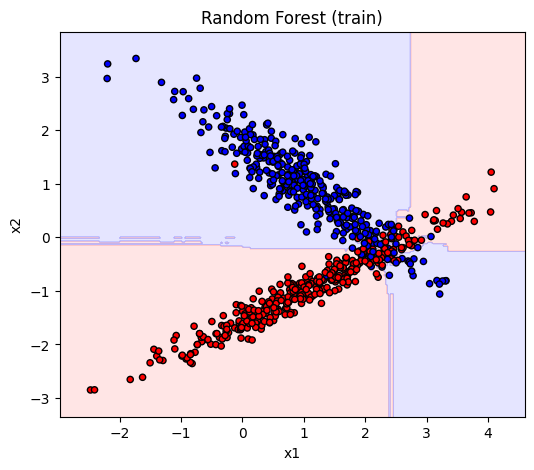

In [10]:
# Decision boundary for Random Forest
plt.figure(figsize=(6,5))
plot_decision_boundary(rf, X_train, y_train, title='Random Forest (train)')


## 4) Feature importance from Random Forest and a single Decision Tree

In [11]:
# Feature importance
fi_rf = rf.feature_importances_
fi_dt = models['None'].feature_importances_  # fully grown tree
fi_df = pd.DataFrame({'feature': ['x1','x2'], 'rf_importance': fi_rf, 'dt_importance': fi_dt})
fi_df


,feature,rf_importance,dt_importance
0,x1,0.220148,0.263932
1,x2,0.779852,0.736068


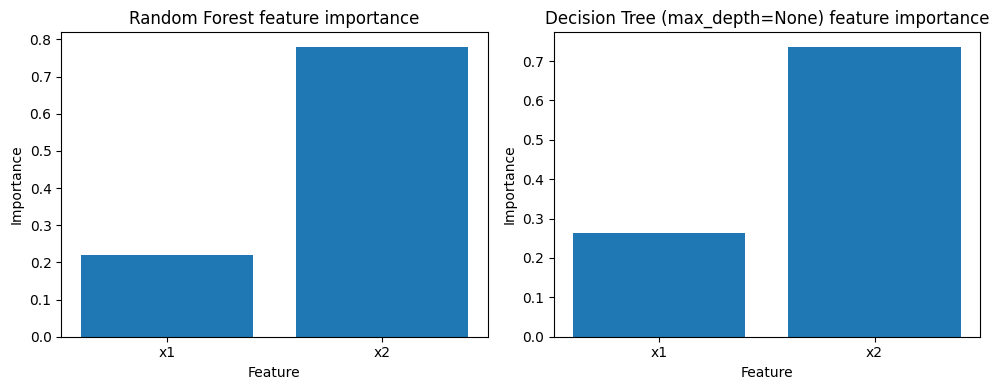

In [12]:
# Plot feature importances
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(fi_df['feature'], fi_df['rf_importance'])
ax[0].set_title('Random Forest feature importance')
ax[1].bar(fi_df['feature'], fi_df['dt_importance'])
ax[1].set_title('Decision Tree (max_depth=None) feature importance')
for a in ax:
    a.set_xlabel('Feature'); a.set_ylabel('Importance')
plt.tight_layout()
plt.show()


## 5) Confusion Matrices

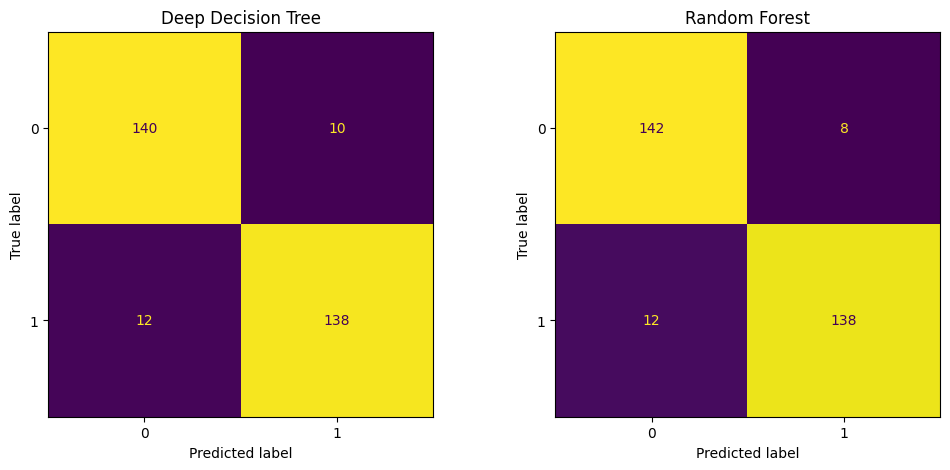

In [13]:
# Confusion matrices for a deep tree and the random forest (test set)
deep_tree = models['None']
fig, axes = plt.subplots(1,2, figsize=(12,5))
for ax, (clf, name) in zip(axes, [(deep_tree, 'Deep Decision Tree'), (rf, 'Random Forest')]):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.show()


## 6) Summary & Key takeaways

- **Underfitting:** Shallow trees (e.g., depth=1) can't capture decision boundaries → low train and test accuracy.
- **Overfitting:** Very deep trees can memorize training data → high train accuracy but lower test accuracy.
- **Random Forest:** By averaging many trees trained on bootstrap samples and feature subsets, Random Forest reduces variance and often improves test accuracy.

---

## References

- Breiman, L. (2001). Random Forests. *Machine Learning*.
- Scikit-learn documentation: Decision trees and Random Forests.

(Include any other papers or blogs you consult in your final tutorial.)
